# Rectangular Surface Code calculations

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import ticker as tick
import numpy as np
import pandas as pd
import statsmodels.stats.proportion as smp
import math
from scipy.stats import binom
from sklearn.linear_model import LinearRegression

from itertools import count as itercnt


import sys
import pickle
np.set_printoptions(threshold=sys.maxsize)

import mpmath

import glob
import json

from mpmath import *

mpmath.prec = 100
mpmath.mp.dps = 100

def binom_cdf(k,n,p):
    x2 = (1-mpmath.mpf(p))
    a = n - k
    b = k + 1
    v = x2**a * mpmath.hyp2f1(a, 1-b, a+1, x2, maxprec = 1000000) / a
    v /= mpmath.beta(a,b)
    return v

CW = 5
CH = 4

In [6]:
def plot_vals(W, H, filename, probs, estimates, ax):
    estimate_points = estimates[0]
    estimates_val_arrays = estimates[1]
    fig, ((ax1)) = plt.subplots(1, 1)
    plt.rc('text', usetex=True)
    ax1.set_xscale("log", nonpositive='clip')
    ax1.set_yscale("log", nonpositive='clip')
    ax1.set_ylim(ax)
    ax1.set_xlabel("Physical Error Rate")
    ax1.set_ylabel("Logical Error Rate")
    for i in range(len(probs)):
        d = i *2 +3
        s = probs[i]
        x = np.array(s[0])
        y = np.array(s[1])
        y = [(math.inf if p < 1E-10 else p) for p in y]
        ax1.plot(x, y, label=f'$d_Z={d}$')
    for estimate_vals in estimates_val_arrays:
        ax1.plot(estimate_points, estimate_vals,color="grey", linestyle=":")
    ax1.grid(True, which="both", ls="-")
    ax1.legend()
    fig = plt.gcf()
    fig.set_size_inches(W, H)
    fig.tight_layout()
    fig.savefig(filename)
    
def plot_vals_bus(W, H, filename, probs, estimates,ax):
    estimate_points = estimates[0]
    estimates_val_arrays = estimates[1]
    fig, ((ax1)) = plt.subplots(1, 1)
    plt.rc('text', usetex=True)
    ax1.set_xscale("log", nonpositive='clip')
    ax1.set_yscale("log", nonpositive='clip')
    ax1.set_ylim(ax)
    ax1.set_xlabel("Physical Error Rate")
    ax1.set_ylabel("Logical Error Rate")
    for i in range(len(probs)):
        d = i *2 + 3
        s = probs[i]
        x = np.array(s[0])
        y = np.array(s[1])
        y1 = [(math.inf if p < 1E-10 else (p*d)) for p in y]
        y2 = [(math.inf if p < 1E-10 else (1 - binom_cdf(0,d,p))) for p in y]
#         ax1.plot(x, y1, label=f'$d_Z={d}$')
        ax1.plot(x, y2, label=f'$d_Z={d}$')
    for estimate_vals, d in zip(estimates_val_arrays, range(3,100,2)) :
        ax1.plot(estimate_points, [(math.inf if p < 1E-10 else (1 - binom_cdf(0,d,min(p,1)))) for p in estimate_vals],color="grey", linestyle=":")
    ax1.grid(True, which="both", ls="-")
    ax1.legend()
    fig = plt.gcf()
    fig.set_size_inches(W, H)
    fig.tight_layout()
    fig.savefig(filename)
    
def get_short_poly(fx_coefs, d_x, d_z):
    return np.eye(1,int((d_x+1)/2)+1,int((d_x+1)/2)).flatten()* np.polyval(np.array(fx_coefs),d_z)

def get_long_poly_o(alpha, beta, d_x, d_z):
    return np.eye(1,int((d_z+1)/2) + 2,int((d_z+1)/2)).flatten()* beta**((d_z+1)/2) *((d_x*2-1) / (d_z*2-1))*d_z* alpha

def get_long_poly(alpha, beta, d_x, d_z):
    return np.eye(1,int((d_z+1)/2) + 2,int((d_z+1)/2)).flatten()* beta**((d_z+1)/2) *((d_x*2-1) / (d_z*2-1))* alpha


def get_short_estimating_polynomial(d_x, dz):
    if d_x == 3:
        return get_short_poly([5.0E2,-7.5E2,2.5E2], 3, dz)
    elif d_x == 5:
        return get_short_poly([26399,-57295,18522], 5, dz)
    elif d_x == 7:
        return get_short_poly([2.87E6, -1.55E7, 2.75E7], 7, dz)
    else:
        return []

def get_long_estimating_polynomial(d_x, dz):
    if d_x == 3:
        return  get_long_poly(0.09, 95, 3, dz)
    elif d_x == 5:
        return  get_long_poly(0.06, 115, 5, dz)
    elif d_x == 7:
        return  get_long_poly(0.03, 125, 7, dz)
    else:
        return []

def get_estimates_short_o(samp_range, d_x, dz):
    estimate_points = np.geomspace(samp_range[0], samp_range[1], 100)
    estimating_polynomials = [get_short_estimating_polynomial(d_x, i) for i in range(dz[0], dz[1]+1, 2)]
    estimates = [np.array([np.polyval(np.flip(ep), i) for i in estimate_points]) for ep in estimating_polynomials]
    return [estimate_points, estimates]

def get_estimates_short(samp_range, d_x, dz):
    estimate_points = np.geomspace(samp_range[0], samp_range[1], 100)
    estimating_polynomials = [get_short_estimating_polynomial(d_x, i) for i in range(dz[0], dz[1]+1, 2)]
    estimates = [np.array([(1 - binom_cdf(0,d_z, min(2/d_z* np.polyval(np.flip(ep), i),1)))/2 for i in estimate_points]) for ep, d_z in zip(estimating_polynomials, range(dz[0], dz[1]+1, 2))]
    return [estimate_points, estimates]

def get_estimates_long_o(samp_range, d_x, dz):
    estimate_points = np.geomspace(samp_range[0], samp_range[1], 100)
    estimating_polynomials = [get_long_estimating_polynomial(d_x, i) for i in range(dz[0], dz[1]+1, 2)]
    estimates = [[np.polyval(np.flip(ep), i) for i in estimate_points] for ep in estimating_polynomials]
    return [estimate_points, estimates]

def get_estimates_long(samp_range, d_x, dz):
    estimate_points = np.geomspace(samp_range[0], samp_range[1], 100)
    estimating_polynomials = [get_long_estimating_polynomial(d_x, i) for i in range(dz[0], dz[1]+1, 2)]
    estimates = [[(1 - binom_cdf(0,d_z, min(2* np.polyval(np.flip(ep), i),1)))/2 for i in estimate_points] for ep, d_z in zip(estimating_polynomials, range(dz[0], dz[1]+1, 2))]
    return [estimate_points, estimates]

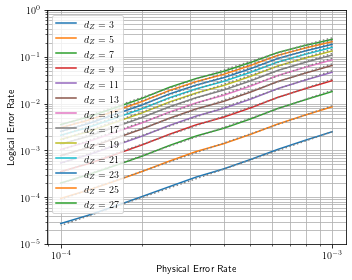

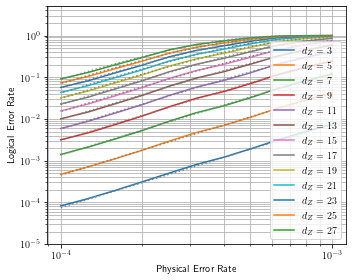

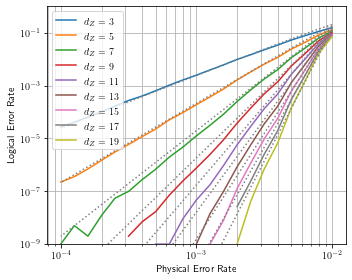

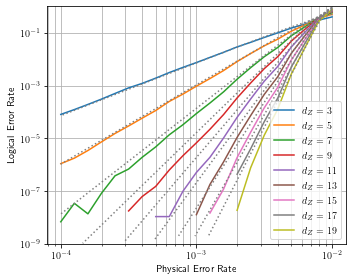

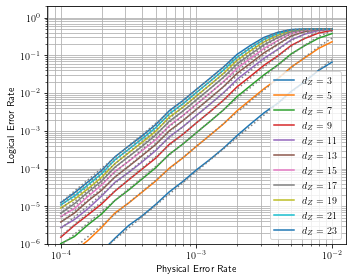

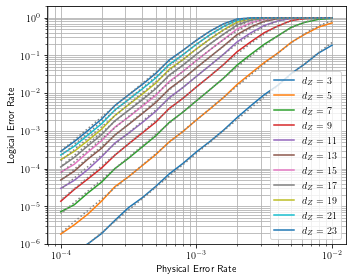

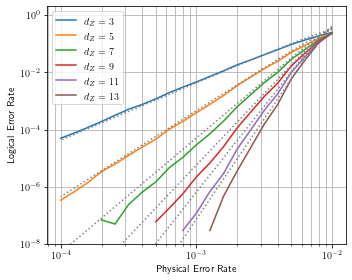

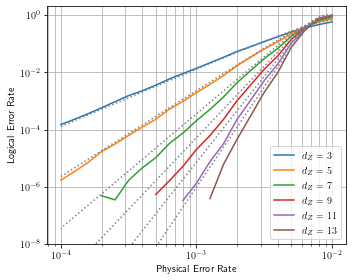

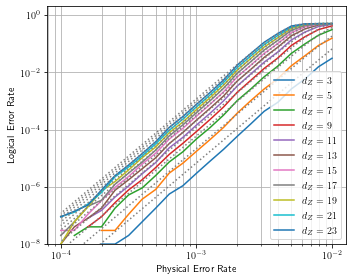

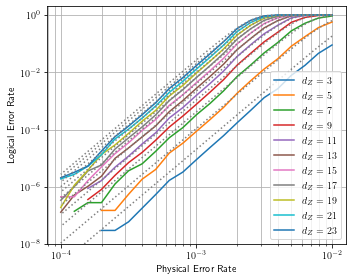

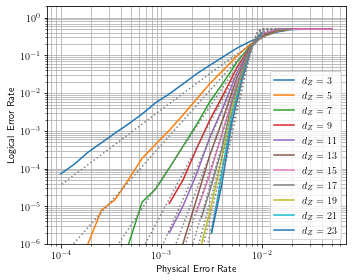

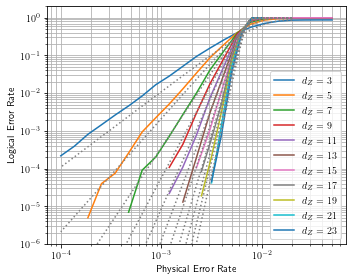

In [7]:
#short edge errors d_x = 3
probs = pickle.load(open("pickles/[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]-[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27]-0.0001-0.001-11-100000000- %2 fixes_atempt1.pickle", "rb"))

estimates = get_estimates_short([1E-3, 1E-4], 3, [3,27])
plot_vals(CW, CH, 'paper_images/dx=3_short.pdf', probs, estimates, [1E-5,1])
plot_vals_bus(CW, CH, 'paper_images/dx=3_short_bus.pdf', probs, estimates,[1E-5,5])

#long edge errors d_x = 3
probs0 = pickle.load(open("pickles/[15, 17, 19]-[3, 3, 3]-0.01-0.001-11-10000000- %2 fixes_atempt1.pickle", "rb"))
probs1 = pickle.load(open("pickles/[15, 17, 19]-[3, 3, 3]-0.005011872336272725-0.001-8-100000000- %2 fixes_atempt1.pickle", "rb"))
probs2 = pickle.load(open("pickles/[15, 17, 19]-[3, 3, 3]-0.003981071705534973-0.001-7-1000000000- %2 fixes_atempt1.pickle", "rb"))
probs3 = pickle.load(open("pickles/[3, 5, 7, 9, 11, 13]-[3, 3, 3, 3, 3, 3]-0.01-0.0001-21-1000000000- %2 fixes_atempt1.pickle", "rb"))

a0 = np.array(probs0)
b0 = np.transpose(a0, [2,0,1])
a1 = np.array(probs1)
b1 = np.transpose(a1, [2,0,1])
a2 = np.array(probs2)
b2 = np.transpose(a2, [2,0,1])
arr = np.concatenate((b0[0:3],b1[0:1],b2))
probs4 = np.transpose(arr, [1,2,0]).tolist()
probs3b = np.array(probs3).tolist()
probs = probs3b + probs4

estimates = get_estimates_long([0.01, 1E-4], 3, [3,19])

plot_vals(CW, CH, 'paper_images/dx=3_long.pdf', probs, estimates,[1/1000000000,1])
plot_vals_bus(CW, CH, 'paper_images/dx=3_long_bus.pdf', probs, estimates,[1/1000000000,1])

#short edge errors, dx = 5
probs0 = pickle.load(open("pickles/[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]-[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23]-[5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]-0.001995262314968879-0.01-8-1000000- %2 fixes_atempt1.pickle", "rb"))
probs1 = pickle.load(open("pickles/[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]-[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23]-[5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]-0.0001-0.001995262314968879-14-100000000- %2 fixes_atempt1.pickle", "rb"))

a0 = np.array(probs0)
b0 = np.transpose(a0, [2,0,1])
a1 = np.array(probs1)
b1 = np.transpose(a1, [2,0,1])
arr = np.concatenate((b1, b0[1:]))
probs = np.transpose(arr, [1,2,0]).tolist()


estimates = get_estimates_short([0.01, 1E-4], 5, [3,23])
plot_vals(CW, CH, 'paper_images/dx=5_short.pdf', probs, estimates,[1/1000000,2])
plot_vals_bus(CW, CH, 'paper_images/dx=5_short_bus.pdf', probs, estimates,[1/1000000,2])

#long edge errors, dx = 5
probs = pickle.load(open("pickles/[3, 5, 7, 9, 11, 13]-[5, 5, 5, 5, 5, 5]-[5, 7, 9, 11, 13, 15]-0.01-0.0001-21-100000000- %2 fixes_atempt1.pickle", "rb"))

estimates = get_estimates_long([0.01, 1E-4], 5, [3,13])
plot_vals(CW, CH, 'paper_images/dx=5_long.pdf', probs, estimates,[1/100000000,2])
plot_vals_bus(CW, CH, 'paper_images/dx=5_long_bus.pdf', probs, estimates,[1/100000000,2])

#short edge errors, dx = 7
#probs = pickle.load(open("pickles/[7, 7, 7, 7, 7, 7, 7]-[3, 5, 7, 9, 11, 13, 15]-[5, 7, 9, 11, 13, 15, 17]-0.05-0.0001-21-1000000- %2 fixes_atempt1.pickle", "rb"))
probs0 = pickle.load(open("pickles/[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]-[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23]-[5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]-0.0001-0.01-21-1000000- %2 fixes_atempt1.pickle", "rb"))
probs1 = pickle.load(open("pickles/[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]-[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23]-[5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]-0.0001-0.001995262314968879-14-100000000- %2 fixes_atempt1.pickle", "rb"))


a0 = np.array(probs0)
b0 = np.transpose(a0, [2,0,1])
a1 = np.array(probs1)
b1 = np.transpose(a1, [2,0,1])
# print(b1.shape)
# print(b0[-7:].shape)
arr = np.concatenate((b1, b0[-7:]))
# arr = b1
# print(arr.shape)
probs = np.transpose(arr, [1,2,0]).tolist()

estimates = get_estimates_short([0.01, 1E-4], 7, [3,23])

plot_vals(CW, CH, 'paper_images/dx=7_short.pdf', probs, estimates,[1E-8,2])
plot_vals_bus(CW, CH, 'paper_images/dx=7_short_bus.pdf', probs, estimates,[1E-8,2])

#long edge errors, dx = 7
probs1 = pickle.load(open("pickles/[3, 5, 7, 9, 11, 13, 15]-[7, 7, 7, 7, 7, 7, 7]-[5, 7, 9, 11, 13, 15, 17]-0.05-0.0001-21-1000000- %2 fixes_atempt1.pickle", "rb"))
probs2 = pickle.load(open("pickles/[17, 19, 21, 23]-[7, 7, 7, 7]-[19, 21, 23, 25]-0.0001-0.01-21-1000000- %2 fixes_atempt1.pickle", "rb"))

probs1 = np.array(probs1).tolist()
probs2 = np.array(probs2).tolist()
probs = probs1 + probs2

estimates = get_estimates_long([0.02, 1E-4], 7, [3,23])
plot_vals(CW, CH, 'paper_images/dx=7_long.pdf', probs, estimates,[1/1000000,2])
plot_vals_bus(CW, CH, 'paper_images/dx=7_long_bus.pdf', probs, estimates,[1/1000000,2])